In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import seaborn as sns
from ExplainableMaximumLikelihoodCalculator import ExplainableMaximumLikelihoodCalculator
import pysam
from Bio import SeqIO, Seq, SeqRecord, pairwise2
from Bio.pairwise2 import format_alignment
from LoadDataUtils import getListOfReadsFromBamFile, getListOfReadsFromFastaFile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math
import shap
from scipy.stats import chisquare
from scipy.special import rel_entr
fileNameSapiens =  "data/simulatedData/human_chinese_AF346973_500samples.fas" #File that contains 500 reads from homo sapiens
fileNameNeanderthals =  "data/simulatedData/Neanderthal_Goyet_KX198085_500samples.fas" #File that contains 500 reads from neanderthal
fileNameDenisovans =  "data/simulatedData/denisova_kx663333_500samples.fas" #File that contains 500 reads from denisovan
neanderthals_500_generated = getListOfReadsFromFastaFile(fileNameNeanderthals)
sapiens_500_generated = getListOfReadsFromFastaFile(fileNameSapiens)
denisovan_500_samples = getListOfReadsFromFastaFile(fileNameDenisovans)
path_to_frequencies_table = "data/substitution_matrix.tsv"
import itertools
 
def findsubsets(s, n):
    subsets = list(itertools.combinations(s, n))
    return [list(a) for a in subsets]

2023-06-19 14:30:05.287193: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-19 14:30:05.849001: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-19 14:30:05.974456: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-19 14:30:05.974474: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [2]:
sapiens_reference_file_names = [
                    "data/reference_files/human_AF346981_French.fa",
                     "data/reference_files/human_AY195760_Korea.fa",
                      "data/reference_files/human_AY882416_Ethiopia.fa",
                      "data/reference_files/human_AY963586_Italian.fa",
                      "data/reference_files/human_AY195781_Caucasian.fa",
                      "data/reference_files/human_AY195757_Iraqi-Israeli.fa",
                      "data/reference_files/human_AY195749_NativeAmerican.fa"]
neanderthals_reference_file_names = [
                            "data/reference_files/neanderthal_mezmaiskaya1_FM865411.fa",
                           "data/reference_files/Neanderthal_Altai_KC879692.fa",
                           "data/reference_files/Neanderthal_Denisova11_full_mtDNA_KU131206.fa",
                           "data/reference_files/Neanderthal_Spy_94a_MG025538.fa",
                            "data/reference_files/Neanderthal_Vindija33.16_AM948965.fa",
                            "data/reference_files/Neanderthal_Vindija33.19_KJ533545.fa"]
denisovan_reference_file_names = [  
                        "data/reference_files/Denisova_MT576653.1.fa",
                        "data/reference_files/Denisova_MT576652.1.fa",
                        "data/reference_files/Denisova_4_FR695060.fa",
                        "data/reference_files/Denisova_8_KT780370.fa",
                        "data/reference_files/Denisova_manual_phalanx_NC_013993.fa",
                        "data/reference_files/Denisova_MT576651.1.fa"]

In [3]:
def generate_sample(sap, nean, den):
    list_before =  list(np.random.choice(sapiens_500_generated, sap)) + list(np.random.choice(neanderthals_500_generated, nean)) + list(np.random.choice(denisovan_500_samples, den))
    l = []
    for i in list_before:
        l.append(str(i))
    return l

In [4]:
def get_counter_factual(ml_estimtator):
    
    shapleys = ml_estimtator.calculate_shapley_values(5000)
    cf = ml_estimtator.generateCounterFactualMinimalSetToRemoveAndChangeMax(shapleys)
    print(cf[0])
    size_of_cf = len(cf[0])
    return size_of_cf
    

In [5]:
def get_cf_based_on_a_s_d(ml_estimtator):
    cf = ml_estimtator.generateCounterFactualMinimalSetToRemoveAndChangeMax_using_a_s_d_values()
    print(cf[0])
    size_of_cf = len(cf[0])
    return size_of_cf
    

In [26]:
def calculate_ground_truth(ml_estimator, sample):
    maxer_before = ml_estimator.estimate_species_proportions().values.argmax()
    sample_indexes = [i for i in range(len(sample))]
    for i in range(len(sample)):
        print("working on size: ", i)
        subsets = findsubsets(sample_indexes, i)
        for to_ignore in subsets:
            result_after = ml_estimator.estimate_species_proportions(ignore_list_indexes=to_ignore).values.argmax()
            if (result_after != maxer_before):
                return (i, to_ignore)
    return (0, [])
        
    
    

In [8]:
import random
results = []
number_of_experiments = 20
for i in range(number_of_experiments):
    size_of_sample = 15
    number_of_sap = random.randint(0,size_of_sample)
    number_of_nean = ((size_of_sample-number_of_sap)*2)//3
    number_of_denisovan = size_of_sample - number_of_sap - number_of_nean
    print(number_of_sap, number_of_nean, number_of_denisovan)
    sample = generate_sample(number_of_sap, number_of_nean, number_of_denisovan)
    maximum_likelihood_calculator_on_sample = ExplainableMaximumLikelihoodCalculator(sample,
                                                ref_neanderthal_file_names=neanderthals_reference_file_names,
                                                ref_sapien_file_names=sapiens_reference_file_names,
                                                ref_denisovan_file_names=denisovan_reference_file_names,
                                                path_to_substitution_matrix=path_to_frequencies_table,
                                                number_of_jobs=-1)
    ground_truth = calculate_ground_truth(maximum_likelihood_calculator_on_sample, sample)
    print("groundtruth:", ground_truth[0])
    print("groundtruth values:", ground_truth[1])
    if (ground_truth[0] == size_of_sample):
        continue
    size_of_cf = get_counter_factual(maximum_likelihood_calculator_on_sample)
    print("counter_factual:", size_of_cf)
    size_of_cf_based_on_a_s_d = counter_factual_based_on_a_s_d = get_cf_based_on_a_s_d(maximum_likelihood_calculator_on_sample)
    print("counter_factualA_s_d:", size_of_cf_based_on_a_s_d)

    results.append((number_of_sap, number_of_nean, number_of_denisovan, ground_truth[0], size_of_cf, size_of_cf_based_on_a_s_d))
    print(results)
    
    

14 0 1
Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  15
start working on read number 0
working on size:  0
working on size:  1
working on size:  2
working on size:  3
working on size:  4
working on size:  5
working on size:  6
working on size:  7
groundtruth: 7
groundtruth values: [2, 3, 5, 6, 9, 11, 12]
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5000
Change dominating species from Homo Sapiens to Neanderthal would require removing 7 reads: [2, 12, 6, 13, 3, 11, 9]
[2, 12, 6, 13, 3, 11, 9]
counter_factual: 7
Change dominating species from Homo Sapiens to Neanderthal would require removing 7 reads: [13, 11, 3, 12, 6, 2, 9]
[13, 11, 3, 12, 6, 2, 9]
counter_factualA_s_d: 7
[(14, 0, 1, 7, 7, 7)]
3 8 4
Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  15
start working on read number 0
working on size:  0
working on size:  1
working on size:  2
groundtruth: 2
groundtruth values: [3, 7]
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5000
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [3, 7]
[3, 7]
counter_factual: 2
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [3, 7]
[3, 7]
counter_factualA_s_d: 2
[(14, 0, 1, 7, 7, 7), (3, 8, 4, 2, 2, 2)]
4 7 4
Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  15
start working on read number 0
working on size:  0
working on size:  1
working on size:  2
groundtruth: 2
groundtruth values: [0, 1]
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5000
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [1, 2]
[1, 2]
counter_factual: 2
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [1, 2]
[1, 2]
counter_factualA_s_d: 2
[(14, 0, 1, 7, 7, 7), (3, 8, 4, 2, 2, 2), (4, 7, 4, 2, 2, 2)]
12 2 1
Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  15
start working on read number 0
working on size:  0
working on size:  1
working on size:  2
working on size:  3
working on size:  4
working on size:  5
groundtruth: 5
groundtruth values: [1, 2, 3, 4, 7]
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5000
Change dominating species from Homo Sapiens to Neanderthal would require removing 5 reads: [1, 9, 2, 11, 3]
[1, 9, 2, 11, 3]
counter_factual: 5
Change dominating species from Homo Sapiens to Neanderthal would require removing 5 reads: [1, 11, 2, 9, 7]
[1, 11, 2, 9, 7]
counter_factualA_s_d: 5
[(14, 0, 1, 7, 7, 7), (3, 8, 4, 2, 2, 2), (4, 7, 4, 2, 2, 2), (12, 2, 1, 5, 5, 5)]
1 9 5
Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  15
start working on read number 0
working on size:  0
working on size:  1
working on size:  2
working on size:  3
working on size:  4
working on size:  5
groundtruth: 5
groundtruth values: [0, 2, 3, 4, 5]
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5000
Change dominating species from Neanderthal to Denisovan would require removing 5 reads: [6, 5, 3, 2, 9]
[6, 5, 3, 2, 9]
counter_factual: 5
Change dominating species from Neanderthal to Denisovan would require removing 5 reads: [3, 5, 9, 6, 1]
[3, 5, 9, 6, 1]
counter_factualA_s_d: 5
[(14, 0, 1, 7, 7, 7), (3, 8, 4, 2, 2, 2), (4, 7, 4, 2, 2, 2), (12, 2, 1, 5, 5, 5), (1, 9, 5, 5, 5, 5)]
9 4 2
Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  15
start working on read number 0
working on size:  0
working on size:  1
working on size:  2
working on size:  3
working on size:  4
working on size:  5
working on size:  6
groundtruth: 6
groundtruth values: [0, 1, 2, 3, 7, 8]
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5000
Change dominating species from Homo Sapiens to Neanderthal would require removing 6 reads: [2, 1, 8, 3, 7, 4]
[2, 1, 8, 3, 7, 4]
counter_factual: 6
Change dominating species from Homo Sapiens to Neanderthal would require removing 6 reads: [2, 8, 1, 3, 7, 12]
[2, 8, 1, 3, 7, 12]
counter_factualA_s_d: 6
[(14, 0, 1, 7, 7, 7), (3, 8, 4, 2, 2, 2), (4, 7, 4, 2, 2, 2), (12, 2, 1, 5, 5, 5), (1, 9, 5, 5, 5, 5), (9, 4, 2, 6, 6, 6)]
3 8 4
Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  15
start working on read number 0
working on size:  0
working on size:  1
working on size:  2
working on size:  3
groundtruth: 3
groundtruth values: [4, 5, 7]
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5000
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [7, 4, 10]
[7, 4, 10]
counter_factual: 3
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [10, 4, 7]
[10, 4, 7]
counter_factualA_s_d: 3
[(14, 0, 1, 7, 7, 7), (3, 8, 4, 2, 2, 2), (4, 7, 4, 2, 2, 2), (12, 2, 1, 5, 5, 5), (1, 9, 5, 5, 5, 5), (9, 4, 2, 6, 6, 6), (3, 8, 4, 3, 3, 3)]
2 8 5
Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  15
start working on read number 0
working on size:  0
working on size:  1
working on size:  2
working on size:  3
groundtruth: 3
groundtruth values: [1, 2, 4]
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5000
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [1, 9, 5]
[1, 9, 5]
counter_factual: 3
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [4, 5, 2]
[4, 5, 2]
counter_factualA_s_d: 3
[(14, 0, 1, 7, 7, 7), (3, 8, 4, 2, 2, 2), (4, 7, 4, 2, 2, 2), (12, 2, 1, 5, 5, 5), (1, 9, 5, 5, 5, 5), (9, 4, 2, 6, 6, 6), (3, 8, 4, 3, 3, 3), (2, 8, 5, 3, 3, 3)]
6 6 3
Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  15
start working on read number 0
working on size:  0
working on size:  1
groundtruth: 1
groundtruth values: [7]
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5000
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [11]
[11]
counter_factual: 1
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [7]
[7]
counter_factualA_s_d: 1
[(14, 0, 1, 7, 7, 7), (3, 8, 4, 2, 2, 2), (4, 7, 4, 2, 2, 2), (12, 2, 1, 5, 5, 5), (1, 9, 5, 5, 5, 5), (9, 4, 2, 6, 6, 6), (3, 8, 4, 3, 3, 3), (2, 8, 5, 3, 3, 3), (6, 6, 3, 1, 1, 1)]
15 0 0
Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  15
start working on read number 0
working on size:  0
working on size:  1
working on size:  2
working on size:  3
working on size:  4
working on size:  5
groundtruth: 5
groundtruth values: [5, 7, 10, 11, 13]
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5000
Change dominating species from Homo Sapiens to Neanderthal would require removing 5 reads: [5, 13, 10, 12, 7]
[5, 13, 10, 12, 7]
counter_factual: 5
Change dominating species from Homo Sapiens to Neanderthal would require removing 6 reads: [5, 11, 10, 12, 7, 13]
[5, 11, 10, 12, 7, 13]
counter_factualA_s_d: 6
[(14, 0, 1, 7, 7, 7), (3, 8, 4, 2, 2, 2), (4, 7, 4, 2, 2, 2), (12, 2, 1, 5, 5, 5), (1, 9, 5, 5, 5, 5), (9, 4, 2, 6, 6, 6), (3, 8, 4, 3, 3, 3), (2, 8, 5, 3, 3, 3), (6, 6, 3, 1, 1, 1), (15, 0, 0, 5, 5, 6)]
8 4 3
Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  15
start working on read number 0
working on size:  0
working on size:  1
working on size:  2
groundtruth: 2
groundtruth values: [9, 11]
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5000
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [9, 11]
[9, 11]
counter_factual: 2
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [11, 9]
[11, 9]
counter_factualA_s_d: 2
[(14, 0, 1, 7, 7, 7), (3, 8, 4, 2, 2, 2), (4, 7, 4, 2, 2, 2), (12, 2, 1, 5, 5, 5), (1, 9, 5, 5, 5, 5), (9, 4, 2, 6, 6, 6), (3, 8, 4, 3, 3, 3), (2, 8, 5, 3, 3, 3), (6, 6, 3, 1, 1, 1), (15, 0, 0, 5, 5, 6), (8, 4, 3, 2, 2, 2)]
6 6 3
Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  15
start working on read number 0
working on size:  0
working on size:  1
working on size:  2
groundtruth: 2
groundtruth values: [6, 7]
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5000
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [8, 9]
[8, 9]
counter_factual: 2
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [8, 10]
[8, 10]
counter_factualA_s_d: 2
[(14, 0, 1, 7, 7, 7), (3, 8, 4, 2, 2, 2), (4, 7, 4, 2, 2, 2), (12, 2, 1, 5, 5, 5), (1, 9, 5, 5, 5, 5), (9, 4, 2, 6, 6, 6), (3, 8, 4, 3, 3, 3), (2, 8, 5, 3, 3, 3), (6, 6, 3, 1, 1, 1), (15, 0, 0, 5, 5, 6), (8, 4, 3, 2, 2, 2), (6, 6, 3, 2, 2, 2)]
6 6 3
Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  15
start working on read number 0
working on size:  0
working on size:  1
working on size:  2
working on size:  3
groundtruth: 3
groundtruth values: [0, 2, 3]
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5000
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [5, 4, 2]
[5, 4, 2]
counter_factual: 3
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [4, 5, 0]
[4, 5, 0]
counter_factualA_s_d: 3
[(14, 0, 1, 7, 7, 7), (3, 8, 4, 2, 2, 2), (4, 7, 4, 2, 2, 2), (12, 2, 1, 5, 5, 5), (1, 9, 5, 5, 5, 5), (9, 4, 2, 6, 6, 6), (3, 8, 4, 3, 3, 3), (2, 8, 5, 3, 3, 3), (6, 6, 3, 1, 1, 1), (15, 0, 0, 5, 5, 6), (8, 4, 3, 2, 2, 2), (6, 6, 3, 2, 2, 2), (6, 6, 3, 3, 3, 3)]
1 9 5
Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  15
start working on read number 0
working on size:  0
working on size:  1
working on size:  2
working on size:  3
groundtruth: 3
groundtruth values: [1, 2, 4]
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5000
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [1, 4, 9]
[1, 4, 9]
counter_factual: 3
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [1, 4, 9]
[1, 4, 9]
counter_factualA_s_d: 3
[(14, 0, 1, 7, 7, 7), (3, 8, 4, 2, 2, 2), (4, 7, 4, 2, 2, 2), (12, 2, 1, 5, 5, 5), (1, 9, 5, 5, 5, 5), (9, 4, 2, 6, 6, 6), (3, 8, 4, 3, 3, 3), (2, 8, 5, 3, 3, 3), (6, 6, 3, 1, 1, 1), (15, 0, 0, 5, 5, 6), (8, 4, 3, 2, 2, 2), (6, 6, 3, 2, 2, 2), (6, 6, 3, 3, 3, 3), (1, 9, 5, 3, 3, 3)]
7 5 3
Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  15
start working on read number 0
working on size:  0
working on size:  1
working on size:  2
groundtruth: 2
groundtruth values: [0, 4]
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5000
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [0, 5]
[0, 5]
counter_factual: 2
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [5, 0]
[5, 0]
counter_factualA_s_d: 2
[(14, 0, 1, 7, 7, 7), (3, 8, 4, 2, 2, 2), (4, 7, 4, 2, 2, 2), (12, 2, 1, 5, 5, 5), (1, 9, 5, 5, 5, 5), (9, 4, 2, 6, 6, 6), (3, 8, 4, 3, 3, 3), (2, 8, 5, 3, 3, 3), (6, 6, 3, 1, 1, 1), (15, 0, 0, 5, 5, 6), (8, 4, 3, 2, 2, 2), (6, 6, 3, 2, 2, 2), (6, 6, 3, 3, 3, 3), (1, 9, 5, 3, 3, 3), (7, 5, 3, 2, 2, 2)]
1 9 5
Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  15
start working on read number 0
working on size:  0
working on size:  1
working on size:  2
groundtruth: 2
groundtruth values: [1, 2]
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5000
Change dominating species from Neanderthal to Denisovan would require removing 2 reads: [9, 6]
[9, 6]
counter_factual: 2
Change dominating species from Neanderthal to Denisovan would require removing 2 reads: [1, 6]
[1, 6]
counter_factualA_s_d: 2
[(14, 0, 1, 7, 7, 7), (3, 8, 4, 2, 2, 2), (4, 7, 4, 2, 2, 2), (12, 2, 1, 5, 5, 5), (1, 9, 5, 5, 5, 5), (9, 4, 2, 6, 6, 6), (3, 8, 4, 3, 3, 3), (2, 8, 5, 3, 3, 3), (6, 6, 3, 1, 1, 1), (15, 0, 0, 5, 5, 6), (8, 4, 3, 2, 2, 2), (6, 6, 3, 2, 2, 2), (6, 6, 3, 3, 3, 3), (1, 9, 5, 3, 3, 3), (7, 5, 3, 2, 2, 2), (1, 9, 5, 2, 2, 2)]
11 2 2
Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  15
start working on read number 0
working on size:  0
working on size:  1
working on size:  2
working on size:  3
working on size:  4
groundtruth: 4
groundtruth values: [0, 1, 2, 6]
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5000
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [6, 0, 2, 9]
[6, 0, 2, 9]
counter_factual: 4
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [6, 1, 7, 0]
[6, 1, 7, 0]
counter_factualA_s_d: 4
[(14, 0, 1, 7, 7, 7), (3, 8, 4, 2, 2, 2), (4, 7, 4, 2, 2, 2), (12, 2, 1, 5, 5, 5), (1, 9, 5, 5, 5, 5), (9, 4, 2, 6, 6, 6), (3, 8, 4, 3, 3, 3), (2, 8, 5, 3, 3, 3), (6, 6, 3, 1, 1, 1), (15, 0, 0, 5, 5, 6), (8, 4, 3, 2, 2, 2), (6, 6, 3, 2, 2, 2), (6, 6, 3, 3, 3, 3), (1, 9, 5, 3, 3, 3), (7, 5, 3, 2, 2, 2), (1, 9, 5, 2, 2, 2), (11, 2, 2, 4, 4, 4)]
8 4 3
Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  15
start working on read number 0
working on size:  0
working on size:  1
working on size:  2
working on size:  3
working on size:  4
groundtruth: 4
groundtruth values: [2, 4, 6, 7]
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5000
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [2, 4, 6, 10]
[2, 4, 6, 10]
counter_factual: 4
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [6, 4, 2, 10]
[6, 4, 2, 10]
counter_factualA_s_d: 4
[(14, 0, 1, 7, 7, 7), (3, 8, 4, 2, 2, 2), (4, 7, 4, 2, 2, 2), (12, 2, 1, 5, 5, 5), (1, 9, 5, 5, 5, 5), (9, 4, 2, 6, 6, 6), (3, 8, 4, 3, 3, 3), (2, 8, 5, 3, 3, 3), (6, 6, 3, 1, 1, 1), (15, 0, 0, 5, 5, 6), (8, 4, 3, 2, 2, 2), (6, 6, 3, 2, 2, 2), (6, 6, 3, 3, 3, 3), (1, 9, 5, 3, 3, 3), (7, 5, 3, 2, 2, 2), (1, 9, 5, 2, 2, 2), (11, 2, 2, 4, 4, 4), (8, 4, 3, 4, 4, 4)]
4 7 4
Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  15
start working on read number 0
working on size:  0
working on size:  1
groundtruth: 1
groundtruth values: [13]
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5000
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [13]
[13]
counter_factual: 1
Change dominating species from Neanderthal to Homo Sapiens would require removing 3 reads: [4, 0, 13]
[4, 0, 13]
counter_factualA_s_d: 3
[(14, 0, 1, 7, 7, 7), (3, 8, 4, 2, 2, 2), (4, 7, 4, 2, 2, 2), (12, 2, 1, 5, 5, 5), (1, 9, 5, 5, 5, 5), (9, 4, 2, 6, 6, 6), (3, 8, 4, 3, 3, 3), (2, 8, 5, 3, 3, 3), (6, 6, 3, 1, 1, 1), (15, 0, 0, 5, 5, 6), (8, 4, 3, 2, 2, 2), (6, 6, 3, 2, 2, 2), (6, 6, 3, 3, 3, 3), (1, 9, 5, 3, 3, 3), (7, 5, 3, 2, 2, 2), (1, 9, 5, 2, 2, 2), (11, 2, 2, 4, 4, 4), (8, 4, 3, 4, 4, 4), (4, 7, 4, 1, 1, 3)]
15 0 0
Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  15
start working on read number 0
working on size:  0
working on size:  1
working on size:  2
working on size:  3
working on size:  4
working on size:  5
working on size:  6
working on size:  7
working on size:  8
working on size:  9
gro

  0%|          | 0/1 [00:00<?, ?it/s]

1
5000
Change dominating species from Homo Sapiens to Neanderthal would require removing 9 reads: [8, 6, 9, 2, 4, 1, 10, 13, 0]
[8, 6, 9, 2, 4, 1, 10, 13, 0]
counter_factual: 9
Change dominating species from Homo Sapiens to Neanderthal would require removing 9 reads: [13, 10, 4, 8, 6, 0, 9, 2, 1]
[13, 10, 4, 8, 6, 0, 9, 2, 1]
counter_factualA_s_d: 9
[(14, 0, 1, 7, 7, 7), (3, 8, 4, 2, 2, 2), (4, 7, 4, 2, 2, 2), (12, 2, 1, 5, 5, 5), (1, 9, 5, 5, 5, 5), (9, 4, 2, 6, 6, 6), (3, 8, 4, 3, 3, 3), (2, 8, 5, 3, 3, 3), (6, 6, 3, 1, 1, 1), (15, 0, 0, 5, 5, 6), (8, 4, 3, 2, 2, 2), (6, 6, 3, 2, 2, 2), (6, 6, 3, 3, 3, 3), (1, 9, 5, 3, 3, 3), (7, 5, 3, 2, 2, 2), (1, 9, 5, 2, 2, 2), (11, 2, 2, 4, 4, 4), (8, 4, 3, 4, 4, 4), (4, 7, 4, 1, 1, 3), (15, 0, 0, 9, 9, 9)]


## We will create datasets of 50%-25%-25% and will run shapley and CF1`

In [9]:
results_a = [(6, 4, 3, 3, 3), (2, 8, 4, 4, 4), (8, 2, 5, 5, 5), (3, 7, 2, 2, 2), (6, 4, 1, 1, 1), (9, 1, 6, 6, 6), (8, 2, 4, 4, 4), (2, 8, 4, 4, 4), (8, 2, 1, 1, 1), (6, 4, 1, 1, 1), (5, 5, 2, 2, 2), (8, 2, 1, 1, 1), (8, 2, 6, 7, 7), (1, 9, 4, 7, 6), (2, 8, 10, 0, 0), (9, 1, 4, 4, 4), (5, 5, 3, 3, 3), (7, 3, 3, 6, 5), (0, 10, 3, 5, 7), (4, 6, 4, 5, 8)]

results_b = [(5, 10, 3, 3, 3), (5, 10, 4, 4, 4), (15, 0, 6, 6, 6), (15, 0, 6, 6, 6), (13, 2, 6, 6, 6), (15, 0, 9, 9, 9), (7, 8, 1, 1, 1), (12, 3, 6, 7, 7), (9, 6, 3, 3, 3), (12, 3, 3, 3, 3), (11, 4, 4, 4, 4), (5, 10, 2, 2, 2), (6, 9, 2, 2, 2), (2, 13, 9, 12, 12), (5, 10, 6, 6, 6), (4, 11, 4, 4, 4), (10, 5, 4, 4, 4), (1, 14, 9, 12, 12), (15, 0, 9, 10, 12), (4, 11, 2, 2, 2)]

results_c = [(12, 2, 1, 4, 4, 4), (8, 4, 3, 3, 3, 3), (2, 8, 5, 1, 1, 1), (12, 2, 1, 5, 5, 5), (15, 0, 0, 8, 8, 8), (5, 6, 4, 2, 2, 2), (11, 2, 2, 6, 6, 6), (6, 6, 3, 5, 5, 5), (5, 6, 4, 1, 1, 1), (7, 5, 3, 1, 1, 1), (14, 0, 1, 5, 5, 5), (7, 5, 3, 1, 1, 1), (13, 1, 1, 8, 8, 8), (8, 4, 3, 4, 4, 4), (4, 7, 4, 1, 1, 1), (15, 0, 0, 8, 8, 8), (2, 8, 5, 1, 1, 1), (1, 9, 5, 3, 3, 4), (13, 1, 1, 5, 5, 5), (14, 0, 1, 4, 4, 4)]

results_d = [(14, 0, 1, 7, 7, 7), (3, 8, 4, 2, 2, 2), (4, 7, 4, 2, 2, 2), (12, 2, 1, 5, 5, 5), (1, 9, 5, 5, 5, 5), (9, 4, 2, 6, 6, 6), (3, 8, 4, 3, 3, 3), (2, 8, 5, 3, 3, 3), (6, 6, 3, 1, 1, 1), (15, 0, 0, 5, 5, 6), (8, 4, 3, 2, 2, 2), (6, 6, 3, 2, 2, 2), (6, 6, 3, 3, 3, 3), (1, 9, 5, 3, 3, 3), (7, 5, 3, 2, 2, 2), (1, 9, 5, 2, 2, 2), (11, 2, 2, 4, 4, 4), (8, 4, 3, 4, 4, 4), (4, 7, 4, 1, 1, 3), (15, 0, 0, 9, 9, 9)]

results_e = [(12, 2, 1, 3, 3, 3), (9, 4, 2, 2, 2, 2), (11, 2, 2, 3, 3, 3), (8, 4, 3, 4, 4, 4), (5, 6, 4, 2, 2, 2), (13, 1, 1, 4, 4, 4), (15, 0, 0, 10, 11, 11), (2, 8, 5, 2, 2, 2), (12, 2, 1, 8, 9, 13), (3, 8, 4, 3, 3, 3), (0, 10, 5, 6, 7, 6), (13, 1, 1, 2, 2, 2), (0, 10, 5, 5, 5, 5), (1, 9, 5, 3, 3, 3), (4, 7, 4, 2, 2, 2), (3, 8, 4, 2, 2, 2), (2, 8, 5, 4, 4, 4), (11, 2, 2, 5, 5, 5), (15, 0, 0, 7, 7, 7), (9, 4, 2, 1, 1, 1)]

In [28]:
results_a = [(6, 4, 0, 3, 3, 3),
 (2, 8, 0, 4, 4, 4),
 (8, 2, 0, 5, 5, 5),
 (3, 7, 0, 2, 2, 2),
 (6, 4, 0, 1, 1, 1),
 (9, 1, 0, 6, 6, 6),
 (8, 2, 0, 4, 4, 4),
 (2, 8, 0, 4, 4, 4),
 (8, 2, 0, 1, 1, 1),
 (6, 4, 0, 1, 1, 1),
 (5, 5, 0, 2, 2, 2),
 (8, 2, 0, 1, 1, 1),
 (8, 2, 0, 6, 7, 7),
 (1, 9, 0, 4, 7, 6),
 (2, 8, 0, 0, 0, 0),
 (9, 1, 0, 4, 4, 4),
 (5, 5, 0, 3, 3, 3),
 (7, 3, 0, 3, 6, 5),
 (0, 10, 0, 3, 5, 7),
 (4, 6, 0, 4, 5, 8)]

In [12]:
results_b = [(t[0], t[1], 0, t[2], t[3], t[4]) for t in results_b]

In [13]:
results_b

[(5, 10, 0, 3, 3, 3),
 (5, 10, 0, 4, 4, 4),
 (15, 0, 0, 6, 6, 6),
 (15, 0, 0, 6, 6, 6),
 (13, 2, 0, 6, 6, 6),
 (15, 0, 0, 9, 9, 9),
 (7, 8, 0, 1, 1, 1),
 (12, 3, 0, 6, 7, 7),
 (9, 6, 0, 3, 3, 3),
 (12, 3, 0, 3, 3, 3),
 (11, 4, 0, 4, 4, 4),
 (5, 10, 0, 2, 2, 2),
 (6, 9, 0, 2, 2, 2),
 (2, 13, 0, 9, 12, 12),
 (5, 10, 0, 6, 6, 6),
 (4, 11, 0, 4, 4, 4),
 (10, 5, 0, 4, 4, 4),
 (1, 14, 0, 9, 12, 12),
 (15, 0, 0, 9, 10, 12),
 (4, 11, 0, 2, 2, 2)]

In [29]:
all = results_a + results_b + results_c + results_d + results_e

In [30]:
ground = [i[3] for i in all]

In [31]:
np.mean(ground)

3.84

In [32]:
diffs_shap = [i[4]-i[3] for i in all]
diffs_a_s_d = [i[5]-i[3] for i in all]

In [35]:
diffs_shap.count(0)

88

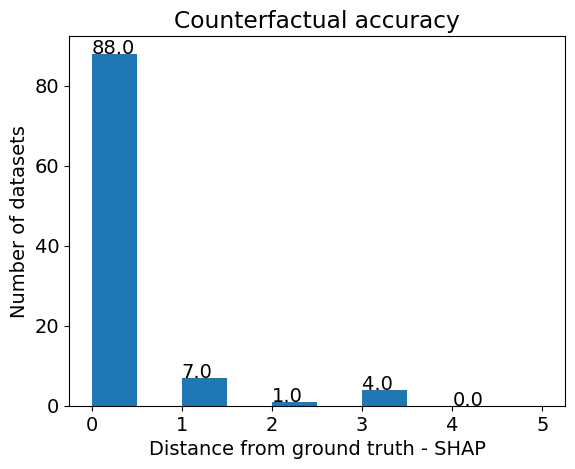

In [38]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 14})

your_bins=10
arr=plt.hist(diffs_shap,bins=your_bins, range=[0, 5])
for i in range(your_bins):
    if (i%2==0):
        plt.text(arr[1][i],arr[0][i],str(arr[0][i]))
plt.ylabel('Number of datasets')
plt.xlabel('Distance from ground truth - SHAP');
plt.title("Counterfactual accuracy")

plt.savefig("accuracy_of_counter_factual_shap.png")

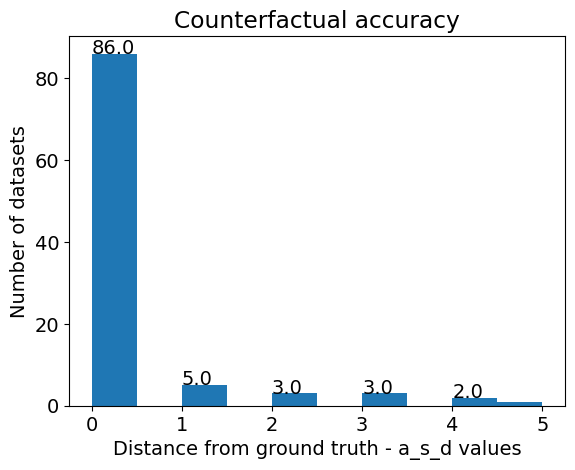

In [39]:

plt.rcParams.update({'font.size': 14})

your_bins=10
arr=plt.hist(diffs_a_s_d,bins=your_bins, range=[0, 5])
for i in range(your_bins):
    if (i%2==0):
        plt.text(arr[1][i],arr[0][i],str(arr[0][i]))
plt.ylabel('Number of datasets')
plt.xlabel('Distance from ground truth - a_s_d values');
plt.title("Counterfactual accuracy")

plt.savefig("accuracy_of_counter_factual_a_s_d.png")